# This notebook produces the dispersion-related figures.

In [1]:
import os,random,time,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.signal.filter import bandpass
from seisgo import noise,utils,dispersion
import pygmt as gmt

#dependency, need to install: scikit-image
from skimage.metrics import structural_similarity as ssim

## Global parameters

In [2]:
dataroot='data_stacking'
raw=os.path.join(dataroot,"MERGED_cascadia_raw")
tnorm=os.path.join(dataroot,"MERGED_cascadia_tnorm")
raw_xz=os.path.join(dataroot,"MERGED_XZ_raw")
tnorm_xz=os.path.join(dataroot,"MERGED_XZ_tnorm")
comp="ZZ"
## Cascadia amphibious array and XZ moveout plots with all stacking methods
figformat="png"
figdpi=300

dlabels=["Raw","One-bit"]
cmap="seismic"
methods=["linear","robust","selective","cluster","pws","tfpws","nroot","acf"]
method_labels=["Linear","Robust","Selective","Cluster","PWS","tf-PWS","$N^{th}$-root","ACF"]
colors=["k","b","c","y","g","orange","r","m"]
figlabels=["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)"]

### XZ moveout plot

In [3]:
XZ_source="XZ.A02"
network_xz="XZ"
with open('xcorr_stacks_allpair_XZ.pk','rb') as xf:
    stack_all_xz=pickle.load(xf)
    dist_all_xz=pickle.load(xf)
flist_xz=[utils.get_filelist(raw_xz+"/"+XZ_source,"h5"),
          utils.get_filelist(tnorm_xz+"/"+XZ_source,"h5")]
i=0
cdict_temp=noise.extract_corrdata(flist_xz[0][0].replace("\n",""),comp=comp)
cdata0=cdict_temp[list(cdict_temp.keys())[0]][comp]
npts_xz=cdata0.data.shape[1] #get number of points.
maxlag_xz=cdata0.lag
dt_xz=cdata0.dt

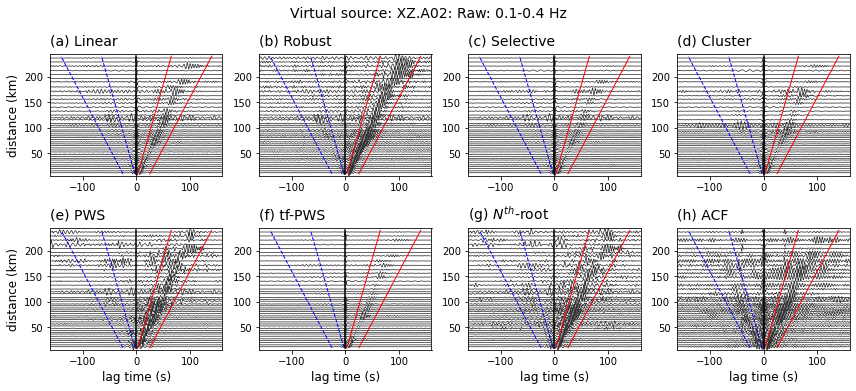

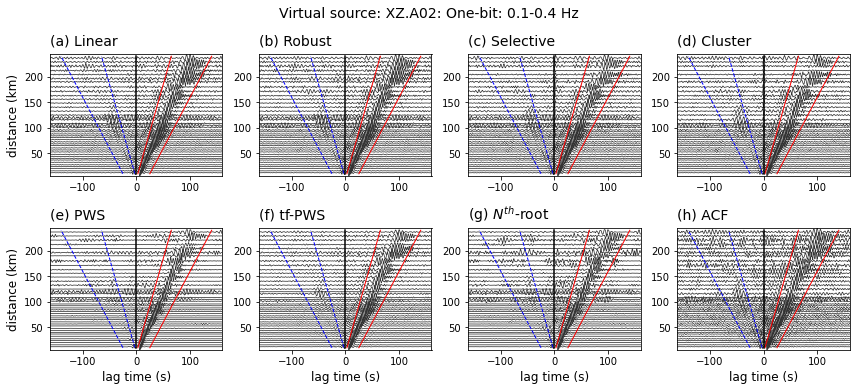

In [4]:
figsize=(12,5.5)
lag=160
scale=8
savefig=False
freqmin_xz,freqmax_xz=[0.1,.4]#[0.04,0.4]
snr_window_extend_xz=20
if lag>maxlag_xz:raise ValueError('lag excceds maxlag!')
tvec_xz=np.arange(-maxlag_xz,maxlag_xz+0.5*dt_xz,dt_xz)
dist_xz=[10,240]
vmin_xz=2
vmax_xz=3.7
for i in range(len(dlabels)):
    fig=plt.figure(figsize=figsize,facecolor='w')
    fig.suptitle("Virtual source: "+XZ_source+": "+dlabels[i]\
                 +": "+str(freqmin_xz)+"-"+str(freqmax_xz)+" Hz",fontsize=14)
    for j,m in enumerate(method_labels):
        plt.subplot(2,4,j+1)
        for k in range(stack_all_xz[dlabels[i]].shape[1]):
            if dist_all_xz[dlabels[i]][k] >= dist_xz[0] and dist_all_xz[dlabels[i]][k] <= dist_xz[1]:
                dp = bandpass(stack_all_xz[dlabels[i]][j,k,:],freqmin_xz,freqmax_xz,1/dt_xz,corners=4, zerophase=True)
                plt.plot(tvec_xz,dist_all_xz[dlabels[i]][k]+scale*dp/np.max(np.abs(dp)),
                             color=[.2,.2,.2],linewidth=0.75,alpha=1)
        # plot signal window
        plt.plot([snr_window_extend_xz + dist_xz[0]/vmin_xz,snr_window_extend_xz+ dist_xz[1]/vmin_xz],
                 dist_xz,'r',lw=1)
        plt.plot([dist_xz[0]/vmax_xz,dist_xz[1]/vmax_xz],dist_xz,'r',lw=1)
        
        plt.plot([-snr_window_extend_xz - dist_xz[0]/vmin_xz,-snr_window_extend_xz- dist_xz[1]/vmin_xz],
                 dist_xz,'b--',lw=1)
        plt.plot([-dist_xz[0]/vmax_xz,-dist_xz[1]/vmax_xz],dist_xz,'b--',lw=1)
        
        plt.xlim([-lag,lag])
        plt.ylim([dist_xz[0]-0.5*scale,dist_xz[1]+0.5*scale])
        if j>=4:
            plt.xlabel('lag time (s)',fontsize=12)
        if j==0 or j==4:
            plt.ylabel('distance (km)',fontsize=12)
#         plt.text(-0.9*lag,dist_xz[0]+20,m,backgroundcolor='w',fontsize=13)
        plt.title('%s %s' % (figlabels[j],m),
                        fontsize=14,loc="left",pad=9)
        plt.plot((0,0),dist_xz,'k-')
    plt.tight_layout()
    if savefig:
        plt.savefig("xcorr_stacks_allpair_moveout_XZ_%s.%s"%(dlabels[i],figformat),dpi=figdpi)
        plt.close()
    else:
        plt.show()

## Dispersion of all pairs
Build the dispersion image with phase-shift method after narrow-band filtering. The dispersion images are then compared among all two datasets with all stacking methods. 

We use the mean image of the one-bit stacks as the reference to quantify the quality of other dispersion images.

We use structural similarity index between two dispersion images as the metric here. Reference for SSI:

* Zhou Wang; Bovik, A.C.; ,”Mean squared error: Love it or leave it? A new look at Signal Fidelity Measures,” Signal Processing Magazine, IEEE, vol. 26, no. 1, pp. 98-117, Jan. 2009.

* Z. Wang, A. C. Bovik, H. R. Sheikh and E. P. Simoncelli, “Image quality assessment: From error visibility to structural similarity,” IEEE Transactions on Image Processing, vol. 13, no. 4, pp. 600-612, Apr. 2004.


## Extract the dispersion image for each stack
We use the `SeisGo` function `dispersion.get_dispersion_image`.

In [5]:
pmin,pmax=[1,15]
vmin,vmax=[1.5,5.5]
dp=0.1
dv=0.05
pband_extend=10
window=1.5
dispall=[]
for i in range(len(dlabels)):
    disp_temp=[]
    for j,m in enumerate(methods):
        print(str(i)+": "+m)
        dout,vout,pout=dispersion.get_dispersion_image(stack_all_xz[dlabels[i]][j,:,:],tvec_xz,
                                                       dist_all_xz[dlabels[i]],pmin=pmin,pmax=pmax,
                                                       dp=dp,vmin=vmin,vmax=vmax,dv=dv,pband_extend=pband_extend,
                                                       window=window)
        disp_temp.append(dout)
    #
    dispall.append(disp_temp)

0: linear
0: robust
0: selective
0: cluster
0: pws
0: tfpws
0: nroot
0: acf
1: linear
1: robust
1: selective
1: cluster
1: pws
1: tfpws
1: nroot
1: acf


## Plot each dispersion image

In [32]:
savefig=True
for i,disp_temp in enumerate(dispall):
    fig=plt.figure(figsize=(12,5.5),facecolor='w')
    fig.suptitle("Virtual source: "+XZ_source+": "+dlabels[i]\
                 +": positive lags",fontsize=14)
    for j,m in enumerate(method_labels):
        dplot=disp_temp[j][1].T.copy()
#         dplot[dplot<0.5]=np.nan
        plt.subplot(2,4,j+1)
        im=plt.imshow(np.flip(dplot),cmap='jet',extent=[pout[-1],pout[0],vout[0],vout[-1]],aspect='auto')
        if j ==0 or j==4: plt.ylabel('velocity (km/s)',fontsize=13)
        if j>3: plt.xlabel('period (s)',fontsize=13)
        plt.xticks(np.arange(pmin,pmax+1,2),fontsize=12)
        plt.yticks(np.arange(vmin,vmax+.5,1),fontsize=12)
        plt.clim([0,1])
#         plt.colorbar(orientation = 'vertical')
        plt.title('%s %s' % (figlabels[j],m),
                        fontsize=14,loc="left",pad=9)

    #
    plt.tight_layout()
    fig.subplots_adjust(right=.925)
    cbar_ax = fig.add_axes([0.94, 0.25, 0.01, 0.5])
    ax=fig.colorbar(im, cax=cbar_ax)
    ax.set_label('normalized energy (power sum)')
    if savefig:
        plt.savefig("dispersion_image_allpair_XZ_%s.%s"%(dlabels[i],figformat),dpi=figdpi)
        plt.close()
    else:
        plt.show()

## Compute the average One-bit image as the reference
This cell computes the average dispersion image and the structural similarity index over the entire frequency/period range.

In [27]:
#### compare with mean of the one-bit
fig=plt.figure(figsize=(10,3.5),facecolor='w')
dispall_array=np.array(dispall)
disp_norm_mean=np.mean(dispall_array[1,:,1],axis=0)
plt.subplot(1,2,1)
plt.imshow(np.flip(dplot),cmap='jet',extent=[pout[-1],pout[0],vout[0],vout[-1]],aspect='auto')
plt.ylabel('velocity (km/s)',fontsize=13)
plt.xlabel('period (s)',fontsize=13)
plt.xticks(np.arange(pmin,pmax+1,2),fontsize=12)
plt.yticks(np.arange(vmin,vmax+.5,1),fontsize=12)
plt.clim([0,1])
ax=plt.colorbar(orientation = 'vertical')
ax.set_label('normalized energy (power sum)')
plt.title('(a) mean %s dispersion image'%(dlabels[1]),
                fontsize=14,loc="left",pad=9)

#
plt.subplot(1,2,2)
markersize=35
for i in range(dispall_array.shape[0]):
    ssi_all=[]
    for j,m in enumerate(method_labels):
        ssi_all.append(ssim(dispall[i][j][1],disp_norm_mean))
    if i==0:
        plt.scatter(np.arange(1,len(method_labels)+1,1),ssi_all,1.2*markersize,'tab:blue',marker='o',facecolor='none',label=dlabels[i])
    else:
        plt.scatter(np.arange(1,len(method_labels)+1,1),ssi_all,markersize,'tab:orange',marker='s',facecolor='k',label=dlabels[i])
plt.grid()
plt.ylabel('SSI',fontsize=13)
plt.ylim([0,1])
plt.yticks(fontsize=12)
plt.xticks(np.arange(1,len(method_labels)+1,1),labels=method_labels,fontsize=13,rotation=30)
plt.title('(b) Structural Similarity Index (SSI) to (a)',
                fontsize=14,loc="left",pad=9)
plt.legend(ncol=2,fontsize=12)
plt.tight_layout()
if savefig:
    plt.savefig("dispersion_image_allpair_XZ_compare.%s"%(figformat),dpi=figdpi)
    plt.close()
else:
    plt.show()

## Move through frequence/period bins in computing SSI
This step creates a frequency-dependent SSI curve for each dispersion image.

In [51]:
savefig=True
pstep=20
plt.figure(figsize=(11,3.5),facecolor='w')

for i in range(dispall_array.shape[0]):
    ssi_all=[]
    plt.subplot(1,2,i+1)
    for j,m in enumerate(method_labels):
        ssi_method=[]
        p_method=[]
        for k in range(disp_norm_mean.shape[0]-pstep):
            ref_subset=disp_norm_mean[k:k+pstep]
            d_subset=dispall[i][j][1][k:k+pstep]
            ssi_method.append(ssim(d_subset,ref_subset))
            p_method.append(np.mean([pout[k],pout[k+pstep]]))
        ssi_all.append(ssi_method)
        plt.plot(p_method,ssi_method,color=colors[j],label=method_labels[j])
    
    plt.grid()
    plt.xlabel('period (s)',fontsize=13)
    plt.ylabel('SSI',fontsize=13)
    plt.ylim([0,1])
    plt.yticks(fontsize=12)
    plt.xticks(np.arange(pmin,pmax+1,2),fontsize=12)
    plt.title('%s period bin of %2.1f s: %s'%(figlabels[i],pstep*dp,dlabels[i]),
                    fontsize=14,loc="left",pad=9)
    if i==1:plt.legend(bbox_to_anchor=(1.01, 1.0),ncol=1,fontsize=12)
plt.tight_layout()
if savefig:
    plt.savefig("dispersion_image_allpair_XZ_compare_byperiods.%s"%(figformat),dpi=figdpi)
    plt.close()
else:
    plt.show()